In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

# Get Data (Prepare many batches of data)

In [2]:
import VP_oscillator_predictor as VPs
import matplotlib.pyplot as plt

In [3]:
params={'a':2,
        'b':-0.8,
        'c':2,
        'd':-10,
        'delta_t':0.01}
Predictor=VPs.VP_O(params)

In [108]:
DATA={}
batch_num=100
T=100

for i in np.arange(batch_num):
    if i<20:
        u=np.cos([i*np.pi/T for i in range(T)])
    else:
        u=np.cos([i*np.pi/T for i in range(T)])
    x0,y0=np.random.random_sample(1)[0],np.random.random_sample(1)[0]
    x,y=Predictor.sim(x0,y0,T,u)
    DATA[i]={'x':x,'y':y,'u':u}

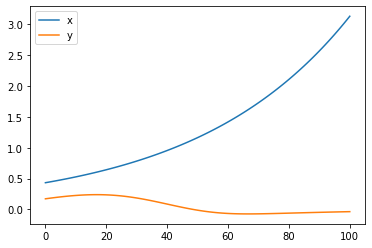

In [109]:
plt.plot(DATA[0]['x'],label='x')
plt.plot(DATA[0]['y'],label='y')
plt.legend()

In [110]:
index=0
X_train=np.concatenate((DATA[index]['x'][0:-1].reshape((-1,1)),DATA[index]['y'][0:-1].reshape((-1,1))),axis=1)
Y_train=np.concatenate((DATA[index]['x'][1:].reshape((-1,1)),DATA[index]['y'][1:].reshape((-1,1))),axis=1)
X_train_F=DATA[index]['u'].reshape((-1,1))
print(X_train.shape,Y_train.shape,X_train_F.shape)

(100, 2) (100, 2) (100, 1)


# Define model (Consider sever steps)

In [111]:
def weight_variable(shape, var_name, distribution='tn', scale=0.1):
    if distribution == 'tn':
        initial = tf.compat.v1.truncated_normal(shape, stddev=scale, dtype=tf.float64)
    elif distribution == 'xavier':
        scale = 4 * np.sqrt(6.0 / (shape[0] + shape[1]))
        initial = tf.compat.v1.random_uniform(shape, minval=-scale, maxval=scale, dtype=tf.float64)
    elif distribution == 'dl':
        # see page 295 of Goodfellow et al's DL book
        # divide by sqrt of m, where m is number of inputs
        scale = 1.0 / np.sqrt(shape[0])
        initial = tf.compat.v1.random_uniform(shape, minval=-scale, maxval=scale, dtype=tf.float64)
    elif distribution == 'he':
        # from He, et al. ICCV 2015 (referenced in Andrew Ng's class)
        # divide by m, where m is number of inputs
        scale = np.sqrt(2.0 / shape[0])
        initial = tf.compat.v1.random_normal(shape, mean=0, stddev=scale, dtype=tf.float64)
    elif distribution == 'glorot_bengio':
        # see page 295 of Goodfellow et al's DL book
        scale = np.sqrt(6.0 / (shape[0] + shape[1]))
        initial = tf.compat.v1.random_uniform(shape, minval=-scale, maxval=scale, dtype=tf.float64)
    else:
        initial = np.loadtxt(distribution, delimiter=',', dtype=np.float64)
        if (initial.shape[0] != shape[0]) or (initial.shape[1] != shape[1]):
            raise ValueError(
                'Initialization for %s is not correct shape. Expecting (%d,%d), but find (%d,%d) in %s.' % (
                    var_name, shape[0], shape[1], initial.shape[0], initial.shape[1], distribution))
    return tf.Variable(initial, name=var_name)


def bias_variable(shape, var_name, distribution=''):
    if distribution:
        initial = np.genfromtxt(distribution, delimiter=',', dtype=np.float64)
    else:
        initial = tf.compat.v1.constant(0.0, shape=shape, dtype=tf.float64)
    return tf.Variable(initial, name=var_name)

In [112]:
class Test_net():
    def __init__(self,params):
        super(Test_net, self).__init__()
        tf.compat.v1.disable_eager_execution()
        self.params=params
        x_in,f_in=self.params['input_layer'],self.params['input_f_layer']
        self.x = tf.compat.v1.placeholder(tf.float64, [None, x_in])
        self.f = tf.compat.v1.placeholder(tf.float64, [None, f_in])
        self.y_bar = tf.compat.v1.placeholder(tf.float64, [None, x_in])
        
        self.weights = dict()
        self.biases = dict()
        
    def encoding_layer(self):
        widths=self.params['encoder_layer']#width be like [[2,3],[3,4]]
        for i in np.arange(len(widths)):
            self.weights['WE%d' % (i)] = weight_variable([widths[i][0], widths[i][1]], var_name='WE%d' % (i))
            self.biases['bE%d' % (i)] = bias_variable([widths[i][1], ], var_name='bE%d' % (i))

    def forcing_layer(self):
        widths=self.params['forcing_layer']#width be like [[2,3],[3,4]]
        for i in np.arange(len(widths)):
            self.weights['Wf%d' % (i)] = weight_variable([widths[i][0], widths[i][1]], var_name='Wf%d' % (i))
            self.biases['bf%d' % (i)] = bias_variable([widths[i][1], ], var_name='bf%d' % (i))

    def decoding_layer(self):
        widths=self.params['decoder_layer']#width be like [[2,3],[3,4]]
        for i in np.arange(len(widths)):
            self.weights['WD%d' % (i)] = weight_variable([widths[i][0], widths[i][1]], var_name='WD%d' % (i))
            self.biases['bD%d' % (i)] = bias_variable([widths[i][1], ], var_name='bD%d' % (i))
            
    def K_layer(self):
        widths=self.params['K_layer']
        self.K = weight_variable(widths, var_name='K')
            
    def forward_net(self):
        
        self.encoding_layer()
        self.forcing_layer()
        self.decoding_layer()
        self.K_layer()
        
        with tf.compat.v1.variable_scope('encoder',reuse=tf.compat.v1.AUTO_REUSE):
            widths=self.params['encoder_layer']
            prev_layer=self.x
            for i in np.arange(len(widths)-1):
                prev_layer = tf.nn.relu(tf.matmul(prev_layer, self.weights['WE%d' % (i)]) + self.biases['bE%d' % (i)])
            self.x_encoder = tf.matmul(prev_layer, self.weights['WE%d' % (len(widths)-1)]) + self.biases['bE%d' % (len(widths)-1)]
             
        with tf.compat.v1.variable_scope('forcing',reuse=tf.compat.v1.AUTO_REUSE):
            widths=self.params['forcing_layer']
            prev_layer=self.f
            for i in np.arange(len(widths)-1):
                prev_layer = tf.nn.relu(tf.matmul(prev_layer, self.weights['Wf%d' % (i)]) + self.biases['bf%d' % (i)])
            self.f_encoder = tf.matmul(prev_layer, self.weights['Wf%d' % (len(widths)-1)]) + self.biases['bf%d' % (len(widths)-1)]
        
        with tf.compat.v1.variable_scope('feature',reuse=tf.compat.v1.AUTO_REUSE):
            self.feature=tf.concat([self.x_encoder,self.f_encoder],axis=1)
        
        with tf.compat.v1.variable_scope('encoder_y',reuse=tf.compat.v1.AUTO_REUSE):
            widths=self.params['encoder_layer']
            prev_layer=self.y_bar
            for i in np.arange(len(widths)-1):
                prev_layer = tf.nn.relu(tf.matmul(prev_layer, self.weights['WE%d' % (i)]) + self.biases['bE%d' % (i)])
            self.y_encoder = tf.matmul(prev_layer, self.weights['WE%d' % (len(widths)-1)]) + self.biases['bE%d' % (len(widths)-1)]
        
        '''
        with tf.compat.v1.variable_scope('K',reuse=tf.compat.v1.AUTO_REUSE):
            #use feature and y_encoder to get K through K=GA
            self.G_inv=tf.compat.v1.matrix_inverse(tf.matmul(tf.transpose(self.feature),self.feature)/300)
            self.A=tf.matmul(tf.transpose(self.feature),self.y_encoder)/300
            self.K=tf.matmul(self.G_inv,self.A)
        '''
            
        '''
        ############################################################################################################################################
        '''  
        
        with tf.compat.v1.variable_scope('advance',reuse=tf.compat.v1.AUTO_REUSE):
            self.x_adv=tf.matmul(self.feature,self.K)
                
        with tf.compat.v1.variable_scope('decoder',reuse=tf.compat.v1.AUTO_REUSE):
            widths=self.params['decoder_layer']
            prev_layer=self.x_adv
            for i in np.arange(len(widths)-1):
                prev_layer = tf.nn.relu(tf.matmul(prev_layer, self.weights['WD%d' % (i)]) + self.biases['bD%d' % (i)])
            self.y = tf.matmul(prev_layer, self.weights['WD%d' % (len(widths)-1)]) + self.biases['bD%d' % (len(widths)-1)]
            
        with tf.compat.v1.variable_scope('decoder_x',reuse=tf.compat.v1.AUTO_REUSE):
            widths=self.params['decoder_layer']
            prev_layer=self.x_encoder
            for i in np.arange(len(widths)-1):
                prev_layer = tf.nn.relu(tf.matmul(prev_layer, self.weights['WD%d' % (i)]) + self.biases['bD%d' % (i)])
            self.x_decoder = tf.matmul(prev_layer, self.weights['WD%d' % (len(widths)-1)]) + self.biases['bD%d' % (len(widths)-1)]
        
        
            
    def loss(self):
        with tf.compat.v1.variable_scope('loss1',reuse=tf.compat.v1.AUTO_REUSE):
            self.loss1 = tf.reduce_mean(tf.square(self.y-self.y_bar))
            
        with tf.compat.v1.variable_scope('loss2',reuse=tf.compat.v1.AUTO_REUSE):
            self.loss2 = tf.reduce_mean(tf.square(self.x_decoder-self.x))
            
        with tf.compat.v1.variable_scope('loss3',reuse=tf.compat.v1.AUTO_REUSE):
            self.loss3 = tf.reduce_mean(tf.square(self.y_encoder-self.x_adv))
            
        with tf.compat.v1.variable_scope('Loss',reuse=tf.compat.v1.AUTO_REUSE):
            self.Loss=self.loss1+self.loss2+self.loss3
    
    def opt(self):
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=self.params['lr'])
        self.train_op = self.optimizer.minimize(self.Loss)



# Training data

In [113]:
params={}
params['encoder_layer']=[[X_train.shape[1],30],[30,30]]
params['decoder_layer']=[[30,30],[30,X_train.shape[1]]]
params['forcing_layer']=[[1,30]]
params['K_layer']=[30+30,30]
params['input_layer']=X_train.shape[1]
params['input_f_layer']=X_train_F.shape[1]
params['lr']=0.001

model=Test_net(params)
model.forward_net()
model.loss()
model.opt()
init_op = tf.compat.v1.global_variables_initializer()

In [114]:
sess=tf.compat.v1.Session()
sess.run(init_op)
saver = tf.compat.v1.train.Saver()
r1,r2=[],[]

In [162]:
epoch=1000
BATCH_NUM=100
for step in np.arange(epoch):
    if np.mod(step,100)==0 and step!=0:
        saver.save(sess, "model/"+str(step)+"model.ckpt")
    for index in np.arange(BATCH_NUM):
        X_train=np.concatenate((DATA[index]['x'][0:-1].reshape((-1,1)),DATA[index]['y'][0:-1].reshape((-1,1))),axis=1)
        Y_train=np.concatenate((DATA[index]['x'][1:].reshape((-1,1)),DATA[index]['y'][1:].reshape((-1,1))),axis=1)
        X_train_F=DATA[index]['u'].reshape((-1,1))
        sess.run(model.train_op,feed_dict={model.x:X_train,model.y_bar:Y_train,model.f:X_train_F})
        r1.append(sess.run(model.Loss,feed_dict={model.x:X_train,model.y_bar:Y_train,model.f:X_train_F}))
        #r2.append(sess.run(model.Loss,feed_dict={model.x:X_test,model.y_bar:Y_test,model.f:X_test_F}))

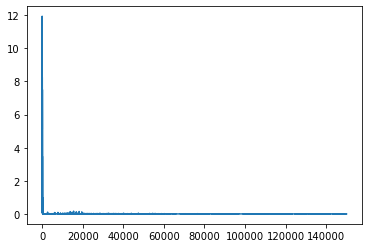

In [163]:
plt.plot(r1)

In [164]:
np.min(r1)

5.307260197829148e-06

# Test

In [183]:
index=12
X_test=np.concatenate((DATA[index]['x'][0:-1].reshape((-1,1)),DATA[index]['y'][0:-1].reshape((-1,1))),axis=1)
Y_test=np.concatenate((DATA[index]['x'][1:].reshape((-1,1)),DATA[index]['y'][1:].reshape((-1,1))),axis=1)
X_test_F=DATA[index]['u'].reshape((-1,1))
print(X_train.shape,Y_train.shape,X_train_F.shape)

(100, 2) (100, 2) (100, 1)


In [184]:
X,Y,XF=X_test,Y_test,X_test_F
x0,u0=X_test[0].reshape((1,-1)),X_test_F[0].reshape((1,-1))
y_reg=[]
for t in np.arange(X_test_F.shape[0]):
    y_=sess.run(model.y,feed_dict={model.x:x0,model.f:u0})
    x0,u0=y_,X_test_F[t].reshape((1,-1))
    y_reg.append(y_.tolist()[0])
y_reg=np.array(y_reg)

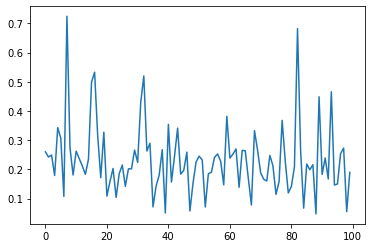

In [188]:
ers=[]

for index in np.arange(100):
    X_test=np.concatenate((DATA[index]['x'][0:-1].reshape((-1,1)),DATA[index]['y'][0:-1].reshape((-1,1))),axis=1)
    Y_test=np.concatenate((DATA[index]['x'][1:].reshape((-1,1)),DATA[index]['y'][1:].reshape((-1,1))),axis=1)
    X_test_F=DATA[index]['u'].reshape((-1,1))
    
    X,Y,XF=X_test,Y_test,X_test_F
    x0,u0=X_test[0].reshape((1,-1)),X_test_F[0].reshape((1,-1))
    y_reg=[]
    for t in np.arange(X_test_F.shape[0]):
        y_=sess.run(model.y,feed_dict={model.x:x0,model.f:u0})
        x0,u0=y_,X_test_F[t].reshape((1,-1))
        y_reg.append(y_.tolist()[0])
    y_reg=np.array(y_reg)
    ers.append(np.mean(np.abs(y_reg-Y)))
plt.plot(ers)

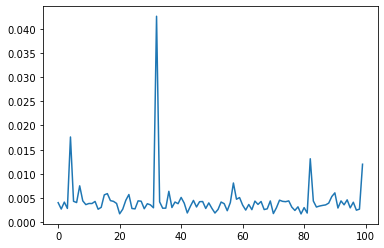

In [190]:
ers=[]

for index in np.arange(100):
    X_test=np.concatenate((DATA[index]['x'][0:-1].reshape((-1,1)),DATA[index]['y'][0:-1].reshape((-1,1))),axis=1)
    Y_test=np.concatenate((DATA[index]['x'][1:].reshape((-1,1)),DATA[index]['y'][1:].reshape((-1,1))),axis=1)
    X_test_F=DATA[index]['u'].reshape((-1,1))
    
    X,Y,XF=X_test,Y_test,X_test_F
    y_reg=sess.run(model.y,feed_dict={model.x:X,model.f:XF})
    ers.append(np.mean(np.abs(y_reg-Y)))
plt.plot(ers)

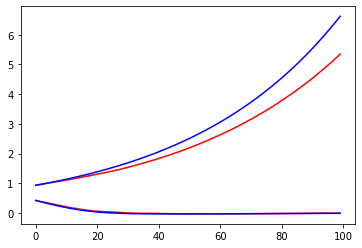

In [185]:
plt.plot(y_reg,'r')
plt.plot(Y,'b')

# Looks Good!!!!

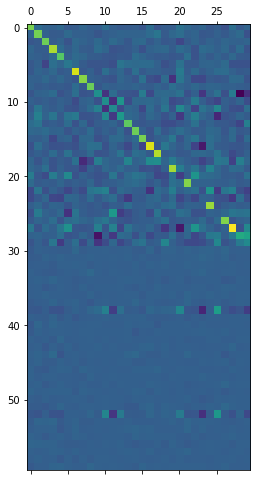

In [168]:
K=sess.run(model.K)
plt.matshow(K)

In [169]:
u,sigma,v=np.linalg.svd(K)

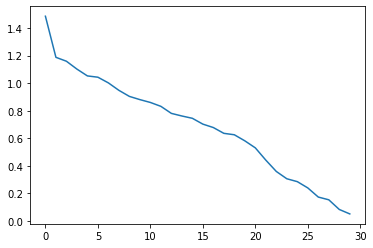

In [170]:
plt.plot(sigma)